# Model Building

This notebook will go over the process of testing different variations of models to find the parameters that best suit the model for this application. 

* Model Type
* Metric Evaluation
* Hyper Parameter Tuning 


In [ ]:
import sys


In [ ]:
!{sys.executable} -m pip install pymysql

In [1]:
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from scipy.stats.stats import pearsonr
import pandas as pd
import numpy as np
from datetime import datetime
import statistics
import matplotlib.pyplot as plt
import pymysql
import config
import transformations

In [2]:
conn = pymysql.connect(config.host, user=config.username,port=config.port,
                           passwd=config.password)

#gather all historical data to build model
RideWaits = pd.read_sql_query("call DisneyDB.RideWaitQuery('2,7,8,9')", conn)

#transform data for model bulding
RideWaits = transformations.transformData(RideWaits)


C:\Users\chrisA\Documents\DisneyWaitTimes\DisneyWaits\src\transformations.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  RideWaits["Month"] = RideWaits["Date"].dt.month
C:\Users\chrisA\Documents\DisneyWaitTimes\DisneyWaits\src\transformations.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  RideWaits["TimeSinceRideOpen"] = (RideWaits["Date"] - RideWaits["OpeningDate"]).dt.days
C:\Users\chrisA\Documents\DisneyWaitTimes\DisneyWaits\src\transformations.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [3]:
RideWaits.head()

,RideId,Date,Time,Wait,Name,OpeningDate,Tier,Location,IntellectualProp,ParkId,...,CharacterExperience,inEMH,validTime,EMHDay,TimeSinceOpen,TimeSinceMidday,MagicHourType,MinutesSinceOpen,Month,TimeSinceRideOpen
0,46,2018-09-19,09:15:00,10,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,0,0,1,0,0,5,None,15.0,9,820
1,46,2018-09-19,09:30:00,30,Royal Sommerhus,2016-06-21,minor_attraction,,None,2,...,0,0,1,0,0,5,None,30.0,9,820
2,62992,2018-09-19,09:36:00,10,Turtle Talk With Crush,2004-11-16,minor_attraction,Future World,Pixar,2,...,0,0,1,0,0,5,None,36.0,9,5055
3,107785,2018-09-19,09:36:00,10,The Seas with Nemo and Friends,2006-11-27,major_attraction,Future World,Pixar,2,...,0,0,1,0,0,5,None,36.0,9,4314
4,18375495,2018-09-19,09:36:00,20,Frozen Ever After,2016-06-21,major_attraction,World Showcase,Princess,2,...,0,0,1,0,0,5,None,36.0,9,820


The data frame looks quite different than in the prevsious exploratory analysis frame. Certain columns have been removed in an effort to consolidate and extract the vital information that has been seen to make a difference in Wait times. 

In [4]:
keyFeatures = ["Name","MagicHourType", "Tier", "IntellectualProp", "ParkName", "DayOfWeek", "Weekend", "TimeSinceOpen","MinutesSinceOpen", "CharacterExperience", "TimeSinceMidday", "inEMH", "EMHDay"]


In [5]:
keyFeatures

['Name',
 'MagicHourType',
 'Tier',
 'IntellectualProp',
 'ParkName',
 'DayOfWeek',
 'Weekend',
 'TimeSinceOpen',
 'MinutesSinceOpen',
 'CharacterExperience',
 'TimeSinceMidday',
 'inEMH',
 'EMHDay']

We have established to this point that this list of features will cause the most impact on wait times and give the most insight into the dataset. 
These can be broken into categories into the information we are trying to gain:
* Ride Characteristics
    * Name
    * Tier
    * IntellectualProp (Intellectual Property)
    * ParkName (Which park is this ride located in)
    * CharacterExperience (Is this a character experience)
* Time of Day Information
    * DayOfWeek
    * Weekend 
    * TimeSinceOpen (How many hours is it since the park opened that day)
    * TimeSinceMidday (How many hours is it in absolute value since 2pm)
    * inEMH (is this wait time in an Extra magic hour window)
    * EMHDay (is this day at the park an Extra Magic Hour Day)
    * MagicHourType (is this a extra magic morning or an extra magic night)
    * Minutes since park open. This and TimeSinceOpen may add unwanted variance. So I may remove TimeSinceOpen
* Weather
    * SimpleStatus
    
As the dataset grows and the more months and weather characteristics pile in, this list of usable features may expand. For example, temperature is not being included in this list as all the data gathered as of today has been from one week, and the temperature pattern adds no value. 

In [6]:
keyFeatures.append("Wait")
RideWaits["Name"] = pd.Categorical(RideWaits["Name"])
RideWaits["DayOfWeek"] = pd.Categorical(RideWaits["DayOfWeek"])
print(keyFeatures)
RideWaits = RideWaits[keyFeatures]
categoryColumns = RideWaits.select_dtypes(include = ['category']).columns
for col in categoryColumns:
    currentCategorical = pd.get_dummies(RideWaits[col], prefix = str(col+ "_"))
    RideWaits = pd.concat([RideWaits,currentCategorical], axis = 1)
    RideWaits = RideWaits.drop([col], axis = 1)


['Name', 'MagicHourType', 'Tier', 'IntellectualProp', 'ParkName', 'DayOfWeek', 'Weekend', 'TimeSinceOpen', 'MinutesSinceOpen', 'CharacterExperience', 'TimeSinceMidday', 'inEMH', 'EMHDay', 'Wait']


In [7]:
RideWaits.head()

,Weekend,TimeSinceOpen,MinutesSinceOpen,CharacterExperience,TimeSinceMidday,inEMH,EMHDay,Wait,Name__A Pirates Adventure ~ Treasures of the Seven Seas,Name__Alien Swirling Saucers,...,ParkName__Disneys Hollywood Studios,ParkName__EpCot,ParkName__Magic Kingdom Park,DayOfWeek__0,DayOfWeek__1,DayOfWeek__2,DayOfWeek__3,DayOfWeek__4,DayOfWeek__5,DayOfWeek__6
0,0,0,15.0,0,5,0,0,10,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0,30.0,0,5,0,0,30,0,0,...,0,1,0,0,0,1,0,0,0,0
2,0,0,36.0,0,5,0,0,10,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,36.0,0,5,0,0,10,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,36.0,0,5,0,0,20,0,0,...,0,1,0,0,0,1,0,0,0,0


In [8]:
RideWaits.dtypes.value_counts()

uint8      100
int64        7
float64      1
dtype: int64

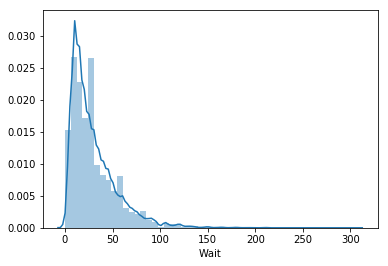

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.distplot(RideWaits["Wait"])

In [ ]:
#almost all of our waits are between 0 and 50 minutes

In [9]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(RideWaits.drop(['Wait'], axis = 1), RideWaits["Wait"], test_size = .25, random_state = 1)

rf = RandomForestRegressor(random_state = 1)
rf.fit(train_x, train_y)
predictions = rf.predict(test_x)
rmseBase = metrics.mean_squared_error(predictions, test_y)**(1/2)
r2Base = metrics.r2_score(predictions, test_y)
varBase = metrics.explained_variance_score(predictions,test_y)
pearsoncorrBase = pearsonr(predictions, test_y)
perrorBase = abs(predictions - test_y)/test_y
accuracyBase = 1 - statistics.median(perrorBase)
errorBase = abs(predictions - test_y)
merrorBase = errorBase.mean()
medErrorBase = statistics.median(errorBase)

In [10]:
print("RMSE: " + str(rmseBase))
print("r2: "+ str(r2Base))
print("var:" + str(varBase))
print("pearsonCorr: "+ str(pearsoncorrBase))
print("Accuracy: " + str(accuracyBase))
print("Mean Error: " + str(merrorBase))
print("Median Error: " + str(medErrorBase))

RMSE: 15.77907720058853
r2: 0.4953648907947068
var:0.4954022484505005
pearsonCorr: (0.7743321576912681, 0.0)
Accuracy: 0.08333333333333326
Mean Error: 10.120797630792502
Median Error: 6.016666666666664


In [ ]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
high_correlations = RideWaits.corr()['Wait']
high_correlations = high_correlations.loc[abs(high_correlations) > .05]
print(high_correlations)

In [ ]:
key_columns = high_correlations.index
RideWaits = RideWaits[key_columns]

In [ ]:
RideWaits.head()

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(RideWaits.drop(['Wait'], axis = 1), RideWaits["Wait"], test_size = .25, random_state = 1)

rf = RandomForestRegressor(random_state = 1)
rf.fit(train_x, train_y)
predictions = rf.predict(test_x)
rmseBase = metrics.mean_squared_error(predictions, test_y)**(1/2)
r2Base = metrics.r2_score(predictions, test_y)
varBase = metrics.explained_variance_score(predictions,test_y)
pearsoncorrBase = pearsonr(predictions, test_y)
perrorBase = abs(predictions - test_y)/test_y
accuracyBase = 1 - statistics.median(perrorBase)
errorBase = abs(predictions - test_y)
merrorBase = errorBase.mean()
medErrorBase = statistics.median(errorBase)

In [ ]:
print("RMSE: " + str(rmseBase))
print("r2: "+ str(r2Base))
print("var:" + str(varBase))
print("pearsonCorr: "+ str(pearsoncorrBase))
print("Accuracy: " + str(accuracyBase))
print("Mean Error: " + str(merrorBase))
print("Median Error: " + str(medErrorBase))

By using the defaults of the Random forest regressor we can get some baseline statistics with this algorithm. We see we have a high correlation meaning that our predictions are following the proper trend of our data. Our accuracy for our base model is 85% and is not a bad start, we also see that both our mean and median wait time error values are under 10 minutes which is also a good place to start. We can now try some other modeling methods as well as tune the hyper parameters for our random forest 
model. 

We are going to start with attempting to tune the hyper parameters for this model

Our focus will be on the following parameters: 
* n_estimators
* max_features
* max_depth
* min_samples_split
* min_samples_leaf
* bootstrap

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10,110, num = 11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rfNew = RandomForestRegressor()
rf_randomized = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 1, n_jobs = -1)

In [ ]:
rf_randomized.fit(train_x, train_y)

In [ ]:
rf_randomized.best_params_

In [ ]:
rf_random = rf_randomized.best_estimator_

In [ ]:
predictions = rf_random.predict(test_x)
rmseRandom = metrics.mean_squared_error(predictions, test_y)**(1/2)
r2Random = metrics.r2_score(predictions, test_y)
varRandom = metrics.explained_variance_score(predictions,test_y)
pearsoncorrRandom = pearsonr(predictions, test_y)
perrorRandom = abs(predictions - test_y)/test_y
accuracyRandom = 1 - statistics.median(perrorRandom)
errorRandom = abs(predictions - test_y)
merrorRandom = errorRandom.mean()
medErrorRandom = statistics.median(errorRandom)

In [ ]:
print("RMSE: " + str(rmseRandom))
print("r2: "+ str(r2Random))
print("var:" + str(varRandom))
print("pearsonCorr: "+ str(pearsoncorrRandom))
print("Accuracy: " + str(accuracyRandom))
print("Mean Error: " + str(merrorRandom))
print("Median Error: " + str(medErrorRandom))

We see a very slight increase in RMSE, mean error, and median Error, but see no increase in overall accuracy.

In [ ]:
gridSearch = {'bootstrap': [True],
              'max_depth' : [60,70,80,90],
              'max_features': ['auto',6,7,8,9,10],
              'min_samples_leaf': [1,2,3,4],
              'min_samples_split': [4,5,6,7],
              'n_estimators' : [800,1200,1600,1800,2000]}

In [ ]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor()
grid_search_rf = GridSearchCV(estimator = rf, param_grid = gridSearch, cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search_rf.fit(train_x, train_y)

In [ ]:
grid_search_rf.best_params_

In [ ]:
best_grid = grid_search_rf.best_estimator_

In [ ]:
predictions = best_grid.predict(test_x)
rmseGrid = metrics.mean_squared_error(predictions, test_y)**(1/2)
r2Grid = metrics.r2_score(predictions, test_y)
varGrid = metrics.explained_variance_score(predictions,test_y)
pearsoncorrGrid = pearsonr(predictions, test_y)
perrorGrid = abs(predictions - test_y)/test_y
accuracyGrid = 1 - statistics.median(perrorGrid)
errorGrid = abs(predictions - test_y)
merrorGrid = errorGrid.mean()
medErrorGrid = statistics.median(errorGrid)

In [ ]:
print("RMSE: " + str(rmseGrid))
print("r2: "+ str(r2Grid))
print("var:" + str(varGrid))
print("pearsonCorr: "+ str(pearsoncorrGrid))
print("Accuracy: " + str(accuracyGrid))
print("Mean Error: " + str(merrorGrid))
print("Median Error: " + str(medErrorGrid))

A slight increase in accuracy but negligible effects across the board in most other categories

## Cross validation
Using the internal cross validation packages we can compute scores without worrying about over fitting or tuning hyper parameters to specific data sets. This can cause a pseudo leakage of our testing data into the training set. We will start the cross validation with the random forest regressor we got from the best estimator from the grid search.

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
rf = RandomForestRegressor(bootstrap = True, max_depth = 50, max_features = 7, min_samples_leaf = 1, n_estimators = 500)

In [ ]:
key_features

In [ ]:
RideWaits.head()

In [ ]:
scores = cross_val_score(rf, RideWaits[key_columns].drop(['Wait']), RideWaits["Wait"], cv = 10)

In [ ]:
scores

This is just a single metric, it is perhaps more useful to obtain a number of metrics for each of our cross validated models.

In [ ]:
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
def cross_validation_metrics(df,  target, folds, key_cols = None,):
    df = df.dropna(how = 'any')
    if key_cols is None:
        X = df.drop(target, axis = 1)
    else:
        X = df[key_cols]
    y = np.array(df[target])
    overall_rmse = []
    overall_accuracy = []
    overall_median_error = []
    overall_mean_error = []
    overall_r2 = []
    corr = []
    kf = KFold(n_splits = folds)
    i = 1
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf = RandomForestRegressor(n_estimators = 250,max_features = 'auto', min_samples_split = 4, min_samples_leaf = 1,max_depth = 60)
        rf.fit(X_train, y_train)
        predictions = rf.predict(X_test)
        predictions = predictions[y_test>0]
        y_test = y_test[y_test>0]
        rmse = metrics.mean_squared_error(predictions, y_test)**(1/2)
        var = metrics.explained_variance_score(predictions,y_test)
        pearsoncorr = pearsonr(predictions, np.array(y_test))
        perror = abs(predictions - y_test)/y_test
        mperror = statistics.median(perror)
        error = abs(predictions - y_test)
        merror = error.mean()
        print("Fold " + str(i))
        print("RMSE: "+ str(rmse))
        print("Correlation: "+ str(pearsoncorr))
        print("Accuracy: " + str(1-mperror))
        print("Mean Error: "+ str(merror))
        print("Median Error: "+ str(statistics.median(error)))
        print("-------------------------")
        overall_rmse.append(rmse)
        overall_accuracy.append((1-mperror))
        overall_median_error.append(statistics.median(error))
        overall_mean_error.append(merror)
        #overall_r2.append(r2)
        corr.append(pearsoncorr[0])
        i = i+1
    
    return_dict = {
        'rmse': np.mean(overall_rmse),
        'accuracy': np.mean(overall_accuracy),
        'median_error': np.mean(overall_median_error),
        'mean_error' : np.mean(overall_mean_error),
        'correlation':np.mean(corr)
    }
    return return_dict


In [ ]:
model_metrics = cross_validation_metrics(RideWaits,"Wait",10)

In [ ]:
model_metrics

In [ ]:
metric_frame = pd.DataFrame(list(model_metrics.items()), columns = ['Metric Name', 'Metric Value'])

In [ ]:
metric_frame